<a href="https://colab.research.google.com/github/vala1958/network/blob/main/myactive_inference_with_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 pip install inferactively-pymdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 248.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymdp import utils

from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable

import itertools

from pymdp.control import construct_policies

In [3]:
class GridWorldEnv():
    
    def __init__(self,starting_state = (0,0)):

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self,action_label):

        (Y, X) = self.current_state

        if action_label == "UP": 
          
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN": 

          Y_new = Y + 1 if Y < 2 else Y
          X_new = X

        elif action_label == "LEFT": 
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT": 
          Y_new = Y
          X_new = X +1 if X < 2 else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X 
        
        self.current_state = (Y_new, X_new) # store the new grid location

        obs = self.current_state # agent always directly observes the grid location they're in 

        return obs

    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs

In [4]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show() 

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B 


def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs  


""" define component functions for computing expected free energy """

def get_expected_states(B, qs_current, action):
  """ Compute the expected states one step into the future, given a particular action """
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

def get_expected_observations(A, qs_u):
  """ Compute the expected observations one step into the future, given a particular action """

  qo_u = A.dot(qs_u)

  return qo_u

def entropy(A):
  """ Compute the entropy of a set of conditional distributions, i.e. one entropy value per column """

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(qo_u, C):
  """ Compute the Kullback-Leibler divergence between two 1-D categorical distributions"""
  
  return (log_stable(qo_u) - log_stable(C)).dot(qo_u) 



def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G   



""" Write a function that, when called, runs the entire active inference loop for a desired number of timesteps"""

def run_active_inference_loop(A, B, C, D, actions, env, T = 5):

  """ Initialize the prior that will be passed in during inference to be the same as `D` """
  prior = D.copy() # initial prior should be the D vector

  """ Initialize the observation that will be passed in during inference - hint use env.reset()"""
  obs = env.reset() # initialize the `obs` variable to be the first observation you sample from the environment, before `step`-ing it.

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = grid_locations.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)

    plot_beliefs(qs_current, title_str = f"Beliefs about location at time {t}")

    # calculate expected free energy of actions
    G = calculate_G(A, B, C, qs_current, actions)
    
    # compute action posterior
    Q_u = softmax(-G)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(Q_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # update generative process
    action_label = actions[chosen_action]

    obs = env.step(action_label)
  
  return qs_current


def calculate_G_policies(A, B, C, qs_current, policies):

  G = np.zeros(len(policies)) # initialize the vector of expected free energies, one per policy
  H_A = entropy(A)            # can calculate the entropy of the A matrix beforehand, since it'll be the same for all policies

  for policy_id, policy in enumerate(policies): # loop over policies - policy_id will be the linear index of the policy (0, 1, 2, ...) and `policy` will be a column vector where `policy[t,0]` indexes the action entailed by that policy at time `t`

    t_horizon = policy.shape[0] # temporal depth of the policy

    G_pi = 0.0 # initialize expected free energy for this policy

    for t in range(t_horizon): # loop over temporal depth of the policy

      action = policy[t,0] # action entailed by this particular policy, at time `t`

      # get the past predictive posterior - which is either your current posterior at the current time (not the policy time) or the predictive posterior entailed by this policy, one timstep ago (in policy time)
      if t == 0:
        qs_prev = qs_current 
      else:
        qs_prev = qs_pi_t
        
      qs_pi_t = get_expected_states(B, qs_prev, action) # expected states, under the action entailed by the policy at this particular time
      qo_pi_t = get_expected_observations(A, qs_pi_t)   # expected observations, under the action entailed by the policy at this particular time

      kld = kl_divergence(qo_pi_t, C) # Kullback-Leibler divergence between expected observations and the prior preferences C

      G_pi_t = H_A.dot(qs_pi_t) + kld # predicted uncertainty + predicted divergence, for this policy & timepoint

      G_pi += G_pi_t # accumulate the expected free energy for each timepoint into the overall EFE for the policy

    G[policy_id] += G_pi
  
  return G


def compute_prob_actions(actions, policies, Q_pi):
  P_u = np.zeros(len(actions)) # initialize the vector of probabilities of each action

  for policy_id, policy in enumerate(policies):
    P_u[int(policy[0,0])] += Q_pi[policy_id] # get the marginal probability for the given action, entailed by this policy at the first timestep
  
  P_u = utils.norm_dist(P_u) # normalize the action probabilities
  
  return P_u


def active_inference_with_planning(A, B, C, D, n_actions, env, policy_len = 2, T = 5):

  """ Initialize prior, first observation, and policies """
  
  prior = D # initial prior should be the D vector

  obs = env.reset() # get the initial observation

  policies = construct_policies([n_states], [n_actions], policy_len = policy_len)

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = grid_locations.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)
    plot_beliefs(qs_current, title_str = f"Beliefs about location at time {t}")

    # calculate expected free energy of actions
    G = calculate_G_policies(A, B, C, qs_current, policies)

    # to get action posterior, we marginalize P(u|pi) with the probabilities of each policy Q(pi), given by \sigma(-G)
    Q_pi = softmax(-G)

    # compute the probability of each action
    P_u = compute_prob_actions(actions, policies, Q_pi)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(P_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # step the generative process and get new observation
    action_label = actions[chosen_action]
    obs = env.step(action_label)
  
  return qs_current







Complete Recipe for Active Inference

Sample an observation  ot  from the current state of the environment

Perform inference over hidden states i.e., optimize  q(s)  through free-energy minimization

Calculate expected free energy of actions  G 

Sample action from the posterior over actions  Q(ut)∼σ(−G) .

Use the sampled action  at  to perturb the generative process and go back to step 1.

Let's start by creating a class that will represent the Grid World environment (i.e., generative process) that our active inference agent will navigate within. Note that we don't need to specify the generative process in terms of A and B matrices - the generative process will be as arbitrary and complex as the environment is. The A and B matrices are just the agent's representation of the world and the task, which in this case happen to capture the Markovian, noiseless dynamics of the world perfectly.

1. The A matrix or  P(o∣s) .
The generative model's "prior beliefs" about how hidden states relate to observations

In [6]:
""" Create  the grid locations in the form of a list of (Y, X) tuples -- HINT: use itertools """
grid_locations = list(itertools.product(range(3), repeat = 2))
print(grid_locations)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [9]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [ ]:
""" Create variables for the storing the dimensionalities of the hidden states and the observations """

n_states = len(grid_locations)
n_observations = len(grid_locations)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')

Dimensionality of hidden states: 9
Dimensionality of observations: 9


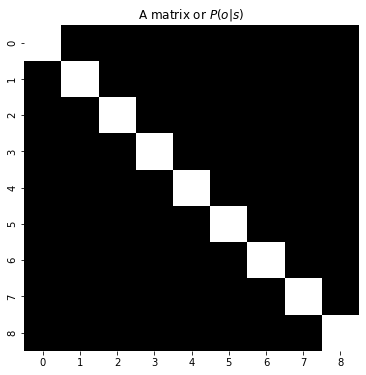

In [7]:



""" Create the A matrix  """

A = np.zeros( (n_states, n_observations) )


""" Create an umambiguous or 'noise-less' mapping between hidden states and observations """

np.fill_diagonal(A, 1.0)

# alternative:
# A = np.eye(n_observations, n_states)

plot_likelihood(A, title_str = "A matrix or $P(o|s)$")

In [ ]:
A_noisy = A.copy()

# this line says: the probability of seeing yourself in location 0, given you're in location 0, is 1/3, AKA P(o == 0 | s == 0) = 0.3333....
A_noisy[0,0] = 1 / 3.0 # corresponds to location (0,0)

# this line says: the probability of seeing yourself in location 1, given you're in location 0, is 1/3, AKA P(o == 1 | s == 0) = 0.3333....
A_noisy[1,0] = 1 / 3.0 # corresponds to one step to the right from (0, 1)

# this line says: the probability of seeing yourself in location 3, given you're in location 0, is 1/3, AKA P(o == 3 | s == 0) = 0.3333....
A_noisy[3,0] = 1 / 3.0 # corresponds to one step down from (1, 0)

plot_likelihood(A_noisy, title_str = 'modified A matrix where location (0,0) is "blurry"')

In [ ]:
""" Let's make ake one grid location "ambiguous" in the sense that it could be easily confused with neighbouring locations """
my_A_noisy = A_noisy.copy()

# locations 3 and 7 are the nearest neighbours to location 6
my_A_noisy[3,6] = 1.0 / 3.0
my_A_noisy[6,6] = 1.0 / 3.0
my_A_noisy[7,6] = 1.0 / 3.0

# Alternatively: you could have the probability spread among locations 3, 4, 6, and 7. This is basically saying, that whole lower-left corner of grid-world is blurry, if you're in location 6
# Remember to make sure the A matrix is column normalized. So if you do it this way, with the probabilities spread among 4 perceived locations, then you'll have to make sure the probabilities sum to 1.0
# my_A_noisy[3,6] = 1.0 / 4.0
# my_A_noisy[4,6] = 1.0 / 4.0
# my_A_noisy[6,6] = 1.0 / 4.0
# my_A_noisy[7,6] = 1.0 / 4.0

plot_likelihood(my_A_noisy, title_str = "Noisy A matrix now with TWO ambiguous locations")

In [ ]:
""" Create an ambiguous A matrix """
A_partially_ambiguous = softmax(A)
print(A_partially_ambiguous.round(3))

2. The B matrix or  P(st∣st−1,ut−1) .
The generative model's "prior beliefs" about (controllable) transitions between hidden states over time. Namely, how do hidden states at time  t  result from hidden states at some previous time  t−1 . These transition dynamics are further conditioned on some past action  ut .

In [ ]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

B = create_B_matrix()

In [ ]:
""" Define a starting location""" 
starting_location = (1,0)

"""get the linear index of the state"""
state_index = grid_locations.index(starting_location)

"""  and create a state vector out of it """
starting_state = utils.onehot(state_index, n_states)

plot_point_on_grid(starting_state, grid_locations)

plot_beliefs(starting_state, "Categorical distribution over the starting state")



""" Generate the next state vector, given the starting state and the B matrix"""
right_action_idx = actions.index("RIGHT") 
next_state = B[:,:, right_action_idx].dot(starting_state) # input the indices to the B matrix

""" Plot the next state, after taking the action """
plot_point_on_grid(next_state, grid_locations)



""" Generate the next state vector, given the previous state and the B matrix"""
prev_state = next_state.copy()
down_action_index = actions.index("DOWN")
next_state = B[:,:,down_action_index].dot(prev_state)

"""  Plot the new state vector, after making the movement """
plot_point_on_grid(next_state, grid_locations)

3. The prior over observations: the  C  vector or  P~(o) 
The (biased) generative model's prior preference for particular observations, encoded in terms of probabilities.

In [ ]:
""" Create an empty vector to store the preferences over observations """
C = np.zeros(n_observations)

""" Choose an observation index to be the 'desired' rewarding index, and fill out the C vector accordingly """
desired_location = (2,2) # choose a desired location
desired_location_index = grid_locations.index(desired_location) # get the linear index of the grid location, in terms of 0 through 8

C[desired_location_index] = 1.0 # set the preference for that location to be 100%, i.e. 1.0

"""  Let's look at the prior preference distribution """
plot_beliefs(C, title_str = "Preferences over observations")

3. The prior over hidden states: the  D  vector or  P(s) 
The generative model's prior belief over hidden states at the first timestep.

In [ ]:
""" Create a D vector, basically a belief that the agent has about its own starting location """

# create a one-hot / certain belief about initial state
D = utils.onehot(0, n_states)

# demonstrate hwo belief about initial state can also be uncertain / spread among different possible initial states
# alternative, where you have a degenerate/noisy prior belief
# D = utils.norm_dist(np.ones(n_states))

""" Let's look at the prior over hidden states """
plot_beliefs(D, title_str = "Prior beliefs over states")

Hidden state inference
Hidden state inference proceeds by finding the setting of the optimal variational posterior  q(st)  that minimizes the variational free energy. For the simple POMDP generative model and posterior we're considering here, this update reduces to a remarkably simple update rule, that is essentially proportional to Bayes` rule:

q(st)=σ(lnA[o,:]+lnB[:,:,u]⋅q(st−1))

YESTERDAYS POSTERIOR IS TODAYS PRIOR !!!!!

The second term (B is in the prior)

In [ ]:
qs_past = utils.onehot(4, n_states) # agent believes they were at location 4 -- i.e. (1,1) one timestep ago

last_action = "UP" # the agent knew it moved "UP" one timestep ago
action_id = actions.index(last_action) # get the action index for moving "UP"

Get "today's prior" using the past posterior and the past action, i.e. calculate:

P(st)=Eq(st−1)[P(st|st−1,ut−1)] 

and choose an observation that is consistent with the new location

In [ ]:
prior = B[:,:,action_id].dot(qs_past)

observation_index = 1

qs_new = infer_states(observation_index, A, prior)
plot_beliefs(qs_new, title_str = "Beliefs about hidden states")

In [ ]:
""" with partly noisy A (oben)... and a noisy prior """
noisy_prior = softmax(prior) 
plot_beliefs(noisy_prior)

""" Do inference with the new, partially-ambiguous A matrix and the noised-up prior """
qs_new = infer_states(observation_index, A_partially_ambiguous, noisy_prior)
plot_beliefs(qs_new)

Now let's use formula for the posterior over actions, i.e.

Q(ut)=σ(−G) 

to compute the probabilities of each action

In [ ]:
Q_u = softmax(-G)

In [10]:
""" Fill out the components of the generative model """

A = np.eye(n_observations, n_states)

B = create_B_matrix()

C = utils.onehot(grid_locations.index( (2, 2) ), n_observations) # make the agent prefer location (2,2) (lower right corner of grid world)

D = utils.onehot(grid_locations.index( (1,2) ), n_states) # start the agent with the prior belief that it starts in location (1,2) 

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

env = GridWorldEnv(starting_state = (1,2))

Starting state is (1, 2)


In [ ]:
""" Run the function we just wrote, for T = 5 timesteps """
qs = run_active_inference_loop(A, B, C, D, actions, env, T = 5)     

Because the expected free energy of each action is only evaluated for one timestep in the future, the agent has no way of knowing which action to initially take, to get closer to its final "goal" of (2,2). This is because the expected divergence term for all actions  DKL(Q(o|u)∥C)  is identical for all considered actions (which are just 1-step moves away from starting from (0,0) ). This speaks to the importance of planning, or multiple timestep policies.

Now let's do active inference with multi-step policies

We can rely on a useful function from pymdp's control module called construct_policies() to automatically generate a list of all the policies we want to entertain, for a given number of control states (actions) and a desired temporal horizon.

In [11]:
policy_len = 4
n_actions = len(actions)

# we have to wrap `n_states` and `n_actions` in a list for reasons that will become clear in Part II
all_policies = construct_policies([n_states], [n_actions], policy_len = policy_len)

print(f'Total number of policies for {n_actions} possible actions and a planning horizon of {policy_len}: {len(all_policies)}')

Total number of policies for 5 possible actions and a planning horizon of 4: 625


Starting state is (0, 0)
Re-initialized location to (0, 0)
..and sampled observation (0, 0)
Time 0: Agent observes itself in location: (0, 0)


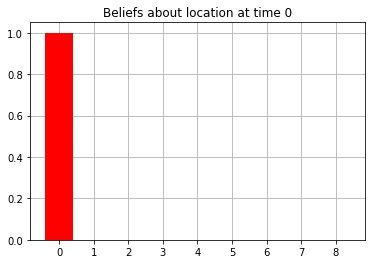

Time 1: Agent observes itself in location: (0, 0)


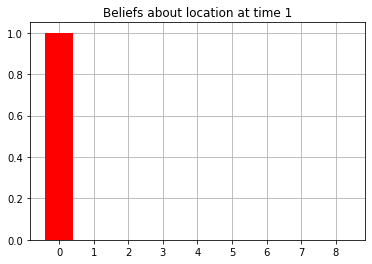

Time 2: Agent observes itself in location: (0, 0)


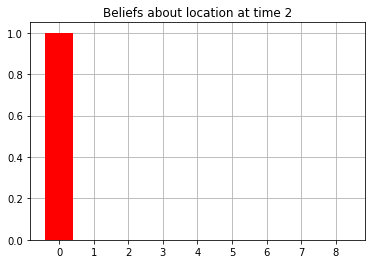

Time 3: Agent observes itself in location: (0, 0)


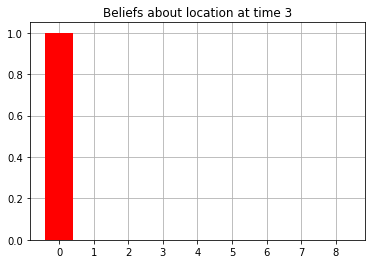

Time 4: Agent observes itself in location: (1, 0)


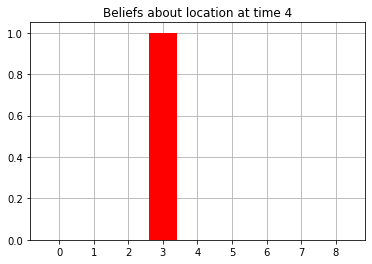

Time 5: Agent observes itself in location: (1, 1)


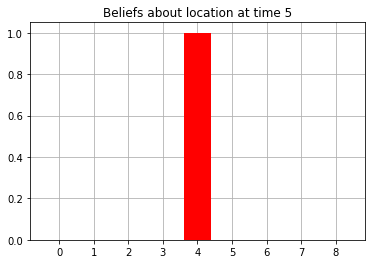

Time 6: Agent observes itself in location: (2, 1)


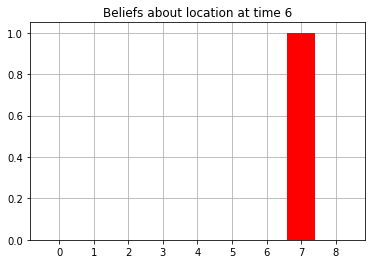

Time 7: Agent observes itself in location: (2, 2)


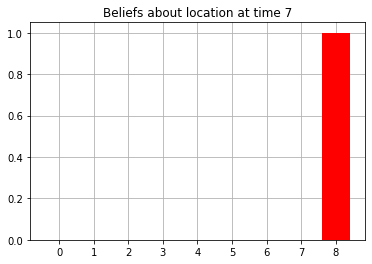

Time 8: Agent observes itself in location: (2, 2)


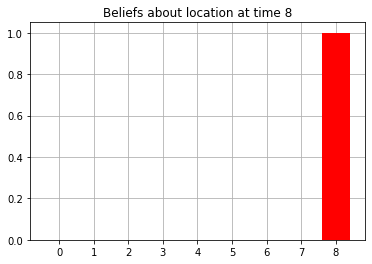

Time 9: Agent observes itself in location: (2, 2)


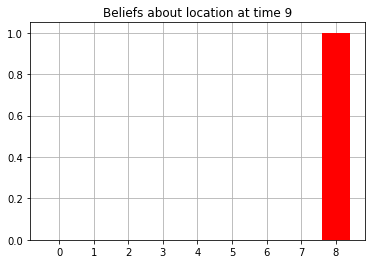

In [12]:
D = utils.onehot(grid_locations.index((0,0)), n_states) # let's have the agent believe it starts in location (0,0) (upper left corner) 
env = GridWorldEnv(starting_state = (0,0))
qs_final = active_inference_with_planning(A, B, C, D, n_actions, env, policy_len = 3, T = 10)